<a href="https://colab.research.google.com/github/govindramesh/segment-anything/blob/main/notebooks/Fine_Tuning_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install torch torchvision torchmetrics &> /dev/null
#! pip install matplotlib &> /dev/null
#! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth &> /dev/null

In [48]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [49]:
%cd /home/govind/segment-anything-1

/home/govind/segment-anything-1


In [50]:
from segment_anything import SamPredictor, sam_model_registry
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
import os

In [51]:
checkpoint = 'sam_vit_b_01ec64.pth'
sam = sam_model_registry['vit_b'](checkpoint=checkpoint)
predictor = SamPredictor(sam)


In [52]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mask_dir):
        self.root_dir = root_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.images[idx])
        mask_name = os.path.join(self.mask_dir, self.images[idx][:-4]+"_label.PNG")

        image = np.asarray(Image.open(img_name))
        mask = np.asarray(Image.open(mask_name))

        return image, mask

In [53]:
# Load custom dataset
dataset = CustomDataset(root_dir='a360_data/Images', mask_dir='a360_data/Masks')

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [54]:
generator = torch.Generator().manual_seed(2)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [270, 30], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor.model.to(device)
predictor.model.train()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [10]:
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([2]).to(device))

optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


In [11]:
for name, param in predictor.model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
  else:
    param.requires_grad_(True)

In [12]:
for epoch in range(2):
    predictor.model.train(True)
    training_loss = 0.0
    for i, data in tqdm(enumerate(train_dataloader, 0), total=len(train_dataloader)):
        inputs, labels = data
        labels = labels.to(device)/255

        inputs = inputs.to(device)

        optimizer.zero_grad()

        predictor.set_image(np.asarray(inputs[0].cpu()))
        masks, scores, logits = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

        loss = criterion(masks[0], labels.float())
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    predictor.model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader, 0), total=len(test_dataloader)):
            inputs, labels = data
            labels = labels.to(device)/255

            inputs = inputs.to(device)

            predictor.set_image(np.asarray(inputs[0].cpu()))
            masks, scores, logits = predictor.predict(
                multimask_output=False,
                return_logits=True
            )
            
            loss = criterion(masks[0], labels.float())
            test_loss += loss.item()
    
    scheduler.step()

    print(f"EPOCH {epoch+1}")
    print(f"TRAINING LOSS: {training_loss/len(train_dataloader)}")
    print(f"TEST LOSS: {test_loss/len(test_dataloader)}")
    
print('Finished Training')

  0%|          | 0/270 [00:00<?, ?it/s]/home/govind/miniconda3/envs/sam/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
100%|██████████| 30/30 [00:06<00:00,  4.63it/s]


EPOCH 1
TRAINING LOSS: 0.6720005868209733
TEST LOSS: 0.48720462471246717


100%|██████████| 30/30 [00:06<00:00,  4.61it/s]

EPOCH 2
TRAINING LOSS: 0.455876708748164
TEST LOSS: 0.42670911848545073
Finished Training


In [13]:
for i in range(0,30):
    with torch.no_grad():
        item = test_dataset.__getitem__(i)[0]
        predictor.set_image(item)
        mask, score, logit = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

    mask[mask < 0] = 0
    mask[mask > 0] = 255
    mask = np.array(mask.cpu()).squeeze().astype(np.uint8)
    im = Image.fromarray(mask)
    im.save(f"validation_masks/masks/mask_{i+1}.png")
    label = np.asarray(test_dataset.__getitem__(i)[1]).squeeze().astype(np.uint8)
    im = Image.fromarray(label)
    im.save(f"validation_masks/labels/label_{i+1}.png")
    raw = np.asarray(test_dataset.__getitem__(i)[0]).squeeze().astype(np.uint8)
    im = Image.fromarray(raw)
    im = im.convert('RGB')
    im.save(f"validation_masks/images/image_{i+1}.png")


In [20]:
print(epsilon)

827.4608416318894


3
simplified contour has 4 points
2
simplified contour has 4 points
1
simplified contour has 4 points
2
simplified contour has 4 points
3
simplified contour has 4 points


<Figure size 640x480 with 0 Axes>

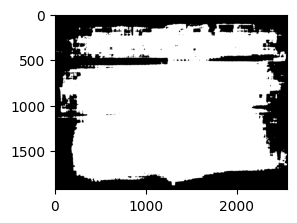

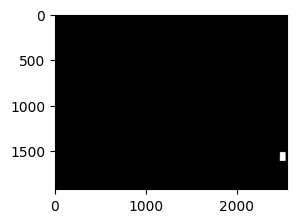

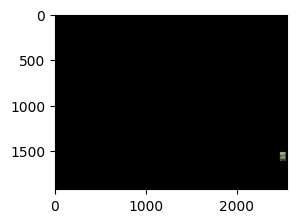

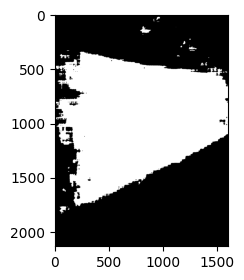

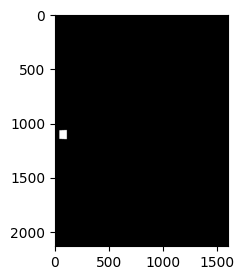

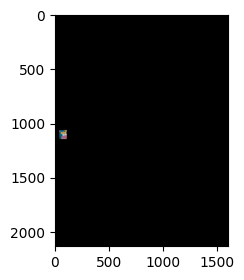

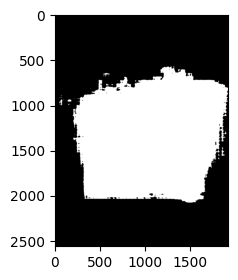

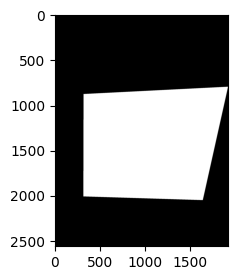

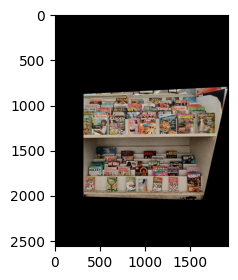

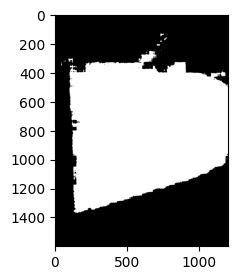

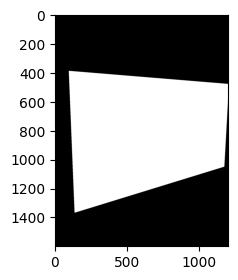

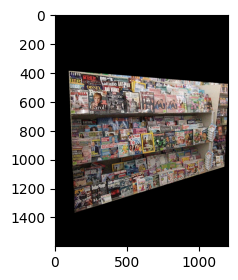

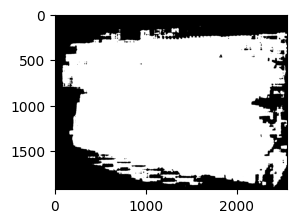

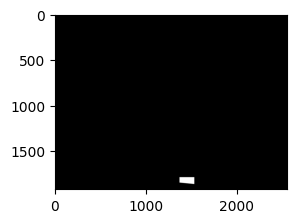

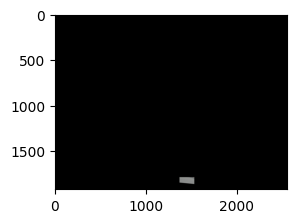

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy
from PIL import Image, ImageDraw

plt.gray()
for i in range(15,20):
    img = cv2.imread(f'/home/govind/segment-anything-1/validation_masks/masks/mask_{i}.png',0)
    plt.figure(figsize=(3,3))
    plt.imshow(img)

    ret,thresh = cv2.threshold(img,127,255,0)
    kernel = np.ones((5,5), np.uint8)

    dilated = img
    for x in range(5):
        eroded = cv2.erode(dilated, kernel, iterations=10)
        
        dilated = cv2.dilate(eroded, kernel, iterations=11)

    # plt.figure(figsize=(3,3))
    # plt.imshow(eroded)
    # plt.figure(figsize=(3,3))
    # plt.imshow(dilated)
    
    contours, hierarchy = cv2.findContours(dilated,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    print(len(contours))

    epsilon = 0.05*cv2.arcLength(contours[0],True)
    approx = cv2.approxPolyDP(contours[0],epsilon,True)

    #cv2.drawContours(img, [approx], 0, (255,255,255), 10)
    print ("simplified contour has",len(approx),"points")


    polygon = [tuple(coord[0]) for coord in approx]
    canvas = Image.new('L', (img.shape[1],img.shape[0]), 0)
    ImageDraw.Draw(canvas).polygon(polygon, outline=1, fill=1)
    mask = numpy.array(canvas)
    plt.figure(figsize=(3,3))
    plt.imshow(mask)

    plt.figure(figsize=(3,3))
    img = np.asarray(test_dataset.__getitem__(i-1)[0]).copy()
    img[mask==0]=0
    plt.imshow(img)

In [ ]:
for i in range(0,10):
    with torch.no_grad():
        item = test_dataset.__getitem__(i)[0]
        predictor.set_image(item)
        mask, score, logit = predictor.predict(
            multimask_output=False,
            return_logits=True
        )

    mask[mask < 0] = 0
    #mask[mask > 0] = 255
    plt.figure(figsize=(3,3))
    output = np.asarray(mask.squeeze().detach().cpu())
    plt.imshow(output)
    plt.figure(figsize=(3,3))
    label = np.asarray(test_dataset.__getitem__(i)[1])
    plt.imshow(label)
    plt.figure(figsize=(3,3))
    img = np.asarray(test_dataset.__getitem__(i)[0]).copy()
    img[output==0]=0
    plt.imshow(img)


In [ ]:
params = []
for param in predictor.model.mask_decoder.parameters():
    params.append(param.view(-1))
params = torch.cat(params)
print(params.shape)
params[0:10]

torch.Size([4058340])


tensor([-0.0140, -0.0091, -0.0464, -0.0625, -0.0070,  0.0468,  0.0213,  0.0293,
         0.0163,  0.0395], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
image = np.asarray(Image.open("MN674339.png"))


FileNotFoundError: [Errno 2] No such file or directory: 'MN674339.png'

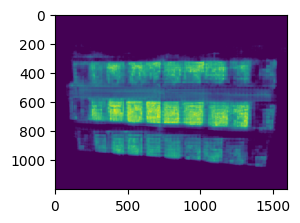

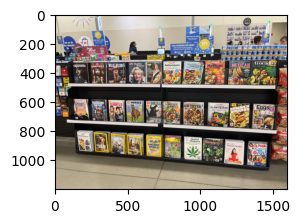

In [ ]:
with torch.no_grad():
    predictor.set_image(image)
    mask, score, logit = predictor.predict(
        multimask_output=False,
        return_logits=True
    )

    mask[mask < 0] = 0
    plt.figure(figsize=(3,3))
    output = np.asarray(mask.squeeze().detach().cpu())
    plt.imshow(output)
    plt.figure(figsize=(3,3))
    plt.imshow(image)